# Importing Libraries 

In [1]:
!pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.5 MB 56.4 MB/s 


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity,manhattan_distances
import seaborn as sns
import implicit 
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
sns.set(style = 'white')

/usr/local/lib/python3.7/dist-packages/implicit/gpu/__init__.py:14: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: no CUDA-capable device is detected (/project/./implicit/gpu/utils.h:71)'
  f"CUDA extension is built, but disabling GPU support because of '{e}'",


# Data Preprocessing




In [3]:
df_food=pd.read_csv('newfooddata2 - Sheet1.csv')
df_food.drop(['UserID','Top 6 most preferred dishes','sum'], axis=1, inplace=True)

In [4]:
df_food = df_food.fillna(0)

one food from each user has been selected as the test data and the index of the column that represents the selected food is saved in a list.

In [5]:
grp_dict={}
test_data={}
grp = df_food.groupby(['Gender','Age Group'])
for name, df in grp:
    df.drop(['Gender','Age Group'], axis=1, inplace=True)
    df=df.reset_index().drop(['index'],axis=1)
    df_mat=np.array(df)
    test_indxs=[]
    ### extract test data ###
    for i in range(len(df)):
        indxs=np.where(np.array(df.iloc[i])==1)[0]
        test_indx=np.random.choice(indxs, size=1)[0]
        df_mat[i][test_indx]=0
        test_indxs.append(test_indx)
    ##########################
    test_data[name]=test_indxs
    grp_dict[name]=df_mat
keys=list(grp_dict.keys())
foods=np.array(df.columns)

In [6]:
df_anly=df_food.groupby(['Gender','Age Group']).sum().reset_index()

In [7]:
df_anly['group id']=[i for i in range(len(df_anly))]

## model1 (features from user-food matrix & cosine similarity)

vectors in the user-food matrix have been directly used as feature vectors 

vectors of food 1 =[0,1,0], food 2=[0,1,1],food 3=[1,1,0]

In [8]:
sim_mat_dic_m1={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    food_similarity_matrix=cosine_similarity(data_matrix,data_matrix) #Find the user-similarity matrix based on cosine similarity
    sim_mat_dic_m1[keys[i]]=food_similarity_matrix

## model 2 (features from Svd & cosine similarity)

svd to generate feature vectors

In [9]:
sim_mat_dic_m2={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    R = np.array(df).T
    mean = np.mean(R, axis = 1)
    data_matrix = R - mean.reshape(-1, 1)
    U, sigma, Vt = svds(data_matrix, k = np.min(data_matrix.shape)-1)
    sigma = np.diag(sigma)
    feature_matrix=np.dot(U, sigma)
    food_similarity_matrix=cosine_similarity(feature_matrix,feature_matrix) #Find the user-similarity matrix based on cosine similarity
    sim_mat_dic_m2[keys[i]]=food_similarity_matrix

## Model3 (features from user-food matrix & euclidean distance similarity)

In [10]:
def euclidean_similarity(matrix1,matrix2):
    euclidean_dist=euclidean_distances(matrix1,matrix2)#find distance 
    scaler = MinMaxScaler()#scale it
    # 
    euclidean_dist_scaled = scaler.fit_transform(euclidean_dist)
    euclidean_sim=1-euclidean_dist_scaled #minus 1 to find similarity 
    return(euclidean_sim)

In [11]:
sim_mat_dic_m3={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    food_similarity_matrix=euclidean_similarity(data_matrix,data_matrix) #Find the user-similarity matrix based on ed similarity
    sim_mat_dic_m3[keys[i]]=food_similarity_matrix

## Model4 (features from user-food matrix & manhattan distance similarity)

In [12]:
def manhattan_similarity(matrix1,matrix2):
    manhattan_dist=manhattan_distances(matrix1,matrix2)#find distance 
    scaler = MinMaxScaler()#scale it
    # transform data
    manhattan_dist_scaled = scaler.fit_transform(manhattan_dist)
    manhattan_sim=1-manhattan_dist_scaled #minus 1 to find similarity 
    return(manhattan_sim)


In [13]:
sim_mat_dic_m5={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    food_similarity_matrix= manhattan_similarity(data_matrix,data_matrix) #Find the user-similarity matrix based on md similarity
    sim_mat_dic_m5[keys[i]]=food_similarity_matrix

# Evaluating models part


In [14]:
def rmse_calc(matrix,test_data_idx):    
    matrix=matrix.T
    ###test data take from indexes
    test=[]
    for i in range(len(matrix)):
        test.append(matrix[i,test_data_idx[i]])
    test=np.array(test)
    err=np.sqrt(np.mean((test-1)**2)) # calculation of  error
    return(err)

In [15]:
def mse_calc(matrix,test_data_idx):    
    matrix=matrix.T
    ###test data take from indexes
    test=[]
    for i in range(len(matrix)):
        test.append(matrix[i,test_data_idx[i]])
    test=np.array(test)
    err=np.mean((test-1)**2) # calculation of  error
    return(err)

In [16]:
def mape_calc(matrix,test_data_idx):    
    matrix=matrix.T
    ###test data take from indexes
    test=[]
    for i in range(len(matrix)):
        test.append(matrix[i,test_data_idx[i]])
    test=np.array(test)
    err=np.mean(abs(test-1)) # calculation of  error
    return(err)

In [17]:
cosine_rmse=[]
euclidean_rmse=[]
mahanttan_rmse=[]
svd_rmse=[]

cosine_mse=[]
euclidean_mse=[]
mahanttan_mse=[]
svd_mse=[]

cosine_mape=[]
euclidean_mape=[]
mahanttan_mape=[]
svd_mape=[]

for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    weight=(1/np.sum(data_matrix!=0,axis=0))
    food_similarity_matrix_m1=sim_mat_dic_m1[keys[i]]
    food_similarity_matrix_m2=sim_mat_dic_m2[keys[i]]
    food_similarity_matrix_m3=sim_mat_dic_m3[keys[i]]
    food_similarity_matrix_m5=sim_mat_dic_m5[keys[i]]
    data_matrix_filed_m1=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m1).T*(data_matrix==0)*weight
    data_matrix_filed_m2=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m2).T*(data_matrix==0)*weight
    data_matrix_filed_m3=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m3).T*(data_matrix==0)*weight
    data_matrix_filed_m5=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m5).T*(data_matrix==0)*weight

    #rmse 
    cosine_rmse.append(rmse_calc(data_matrix_filed_m1,test_data[keys[i]]))
    euclidean_rmse.append(rmse_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mahanttan_rmse.append(rmse_calc(data_matrix_filed_m5,test_data[keys[i]])) 
    svd_rmse.append(rmse_calc(data_matrix_filed_m2,test_data[keys[i]])) 

    #mse
    cosine_mse.append(mse_calc(data_matrix_filed_m1,test_data[keys[i]]))
    euclidean_mse.append(mse_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mahanttan_mse.append(mse_calc(data_matrix_filed_m5,test_data[keys[i]]))
    svd_mse.append(rmse_calc(data_matrix_filed_m2,test_data[keys[i]]))   

    #mape
    cosine_mape.append(mape_calc(data_matrix_filed_m1,test_data[keys[i]]))
    svd_mape.append(mape_calc(data_matrix_filed_m2,test_data[keys[i]]))
    euclidean_mape.append(mape_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mahanttan_mape.append(mape_calc(data_matrix_filed_m5,test_data[keys[i]]))
    ############################################################



values  be predicted using the this

**rating_**{(i,j)} = similarity\_matrix_i * data\_matrix_j*weight  


where, \


similarity\_matrix_i=$ i th raw of user_similarity_matrix\
 data\_matrix_j= j th column of data_matrix_useritem\
weight=1/sum(data\_matrix\_useritem_j !=0)





# Plotting Line Graph with markers at each point 

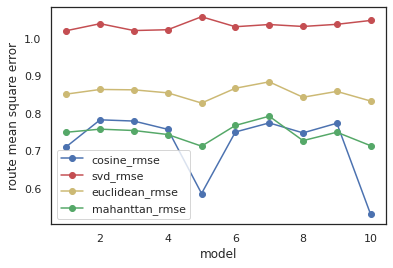

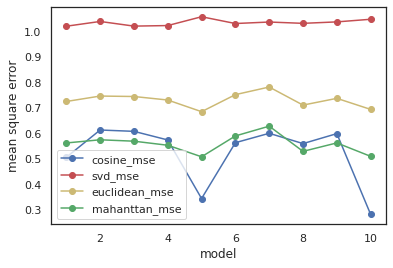

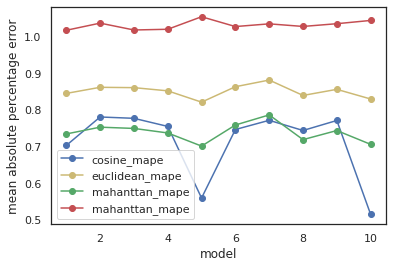

In [18]:
plt.plot([i+1 for i in range(len(cosine_rmse))],cosine_rmse,'b',label='cosine_rmse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],svd_rmse,'r',label='svd_rmse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],euclidean_rmse,'y',label='euclidean_rmse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],mahanttan_rmse,'g',label='mahanttan_rmse', marker = 'o')
plt.legend()
plt.xlabel('model')
plt.ylabel('route mean square error')
plt.show()

plt.plot([i+1 for i in range(len(cosine_rmse))],cosine_mse,'b',label='cosine_mse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],svd_mse,'r',label='svd_mse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],euclidean_mse,'y',label='euclidean_mse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],mahanttan_mse,'g',label='mahanttan_mse', marker = 'o')

plt.legend()
plt.xlabel('model')
plt.ylabel('mean square error')
plt.show()


plt.plot([i+1 for i in range(len(cosine_rmse))],cosine_mape,'b',label='cosine_mape', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],euclidean_mape,'y',label='euclidean_mape', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],mahanttan_mape,'g',label='mahanttan_mape', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],svd_mape,'r',label='mahanttan_mape', marker = 'o')

plt.legend()
plt.xlabel('model')
plt.ylabel('mean absolute percentage error')
plt.show()

# Prediction , recommend top 5

In [19]:
def recommend(Gender,Age_Group,food,sim_mat,top_n):
    sim_mat=sim_mat[(Gender,Age_Group)]#get which gender and agegroup then see which model to use
    idx=np.where(foods==food)[0][0]# get the food and look through
    sim_array=sim_mat[idx]#put the index from the previous line into the sim_mat
    sim_array[idx]=-1000 # minus 1000 to get the idx, forcing that value to large negetive value.
    scores=list(enumerate(sim_array))#To specify each course of a sequence individually
    sorted_array=np.array(sorted(scores,key=lambda x: x[1], reverse=True),dtype='uint8')[:,0]# sort and print top 5
    print(foods[sorted_array[:top_n]])

# **Testing with test cases**

In [20]:
Gender='Female'
Age_Group='15 - 24'
food='Cereal Prawn'
recommend(Gender,Age_Group,food,sim_mat_dic_m1,5)
recommend(Gender,Age_Group,food,sim_mat_dic_m2,5)
recommend(Gender,Age_Group,food,sim_mat_dic_m3,5)
recommend(Gender,Age_Group,food,sim_mat_dic_m5,5)

['Sambal Stingray' 'Chili Crab' 'Japanese Bento' 'Hokkien Mee' 'Satay']
['Sambal Stingray' 'Chili Crab' 'Kway Chap' 'Katong laksa'
 'Crab Bee Hoon Soup']
['Yu Sheng' 'Beef Kway Teow' 'Sambal Stingray' 'Kway Chap'
 'Crab Bee Hoon Soup']
['Yu Sheng' 'Beef Kway Teow' 'Sambal Stingray' 'Kway Chap'
 'Crab Bee Hoon Soup']


In [21]:
Gender='Female'
Age_Group='15 - 24'
food='Japanese Bento'
recommend(Gender,Age_Group,food,sim_mat_dic_m1,5)
recommend(Gender,Age_Group,food,sim_mat_dic_m2,5)
recommend(Gender,Age_Group,food,sim_mat_dic_m3,5)
recommend(Gender,Age_Group,food,sim_mat_dic_m5,5)

['Duck Rice' 'Chili Crab' 'Fish and Chips' 'Kway Chap' 'Char Kway Teow']
['Duck Rice' 'Chili Crab' 'Beef Kway Teow' 'Kway Chap' 'Char Kway Teow']
['Duck Rice' 'Chili Crab' 'Kway Chap' 'Beef Kway Teow' 'Cereal Prawn']
['Duck Rice' 'Chili Crab' 'Kway Chap' 'Beef Kway Teow' 'Cereal Prawn']


In [22]:
Gender='Female'
Age_Group='65 and above'
food='Sliced Fish Soup'
recommend(Gender,Age_Group,food,sim_mat_dic_m1,5)
recommend(Gender,Age_Group,food,sim_mat_dic_m2,5)
recommend(Gender,Age_Group,food,sim_mat_dic_m3,5)
recommend(Gender,Age_Group,food,sim_mat_dic_m5,5)

['Chinese Economy Rice' 'Crab Bee Hoon Soup' 'hainanese chicken rice'
 'Bak Kut Teh' 'Hokkien Mee']
['hainanese chicken rice' 'Katong laksa' 'Chili Crab' 'Cereal Prawn'
 'Sambal Stingray']
['Chinese Economy Rice' 'Crab Bee Hoon Soup' 'Bak Kut Teh'
 'hainanese chicken rice' 'Satay']
['Chinese Economy Rice' 'Crab Bee Hoon Soup' 'Bak Kut Teh'
 'hainanese chicken rice' 'Satay']
